In [18]:
import numpy as np
from scipy.linalg import inv, sqrtm
from copy import copy
import sys, os
from datetime import datetime
sys.path.append("/Users/Colin/Documents/Research/Graduate_Research/Spin_Glasses/")
from replicaExchangeMC import spinUnpack, timeSeriesLoader
import plot_eigenvalue_spectrum as pspec
from itertools import product
from scipy.optimize import leastsq
import cPickle as pickle
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.optimize import approx_fprime
from sfo import SFO

In [2]:
def spatial_corr(spins):
    """
    Given a spin configuration (L,L), returns distance and correlation at that
    distance.
    """
    xl, yl = spins.shape
    xg, yg = np.meshgrid(np.arange(xl/2),np.arange(yl/2))
    d = np.sqrt(xg**2+yg**2)
    psi_k = np.fft.fft2(spins)
    corr = np.real_if_close(np.fft.ifft2(psi_k*np.conj(psi_k)), tol=1000)[:xl/2,:yl/2]
    return d.ravel(), corr.ravel()/(xl*yl)

def corr_form(ksi, A):
    return lambda r: A*np.exp(-r/ksi)*r**(-1/4)

def residuals(x, spins):
    L = spins.shape[0]
    ksi = x[0]
    A = x[1]
    r, corr = spatial_corr(spins)
    form = corr_form(ksi, A)
    fitting = map(form, r)
    return corr - fitting

def fitform(spins):
    x = np.random.rand(2)+1.
    sol = leastsq(residuals, x, args=(spins,))
    return sol

In [103]:
%run rbm.py

In [23]:
isingspins64 = spinUnpack(np.load('../../data/L_64_ising_Tc_N_s_4500.npz')['series'],64).reshape(-1,64**2)
print isingspins64.shape
#np.random.shuffle(isingspins) #So batches don't have correlations

NameError: name 'isingspins' is not defined

In [5]:
isingspins32 = spinUnpack(np.load('../../data/L_32_T_2-45.npz')['arr_0'], 32).reshape(-1, 32**2)
#np.random.shuffle(isingspins32)

In [59]:
spinglasssim = pickle.load(open('data/2120127072-THM_250000-N_MC_10000000-P_50-sim-_disord-287128948_git-f010714c3c.pkl','r'))
spinglasssim.filename = os.path.join('data', os.path.split(spinglasssim.filename)[-1])
spinglassseries = timeSeriesLoader(spinglasssim, skip=40, N_t=6)
print spinglassseries.shape

[ 1.44824204  1.17391682]


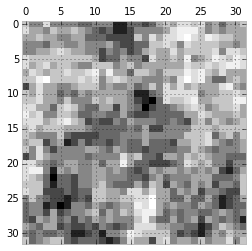

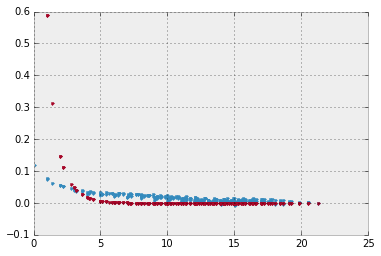

In [52]:
spinarray = isingspins32[40000:40010].mean(axis=0).reshape(32,32)
d, c = spatial_corr(spinarray)
plt.matshow(spinarray, cmap='Greys')
plt.figure()
plt.plot(d, c, '.')
ksi, _ = fitform(spinarray)
print ksi
cp = corr_form(ksi[0], ksi[1])
plt.plot(d, cp(d),'.')

In [104]:
rbm = RBM(isingspins32, N_h = 8*8, verbose=True, sparsity=0.001, mom=0.5, k = 4)

In [11]:
%timeit rbm.compute_model_si_hj()

100 loops, best of 3: 2.13 ms per loop


In [ ]:
%timeit rbm.compute_model_si_hj

In [93]:
rbmsg = RBM(spinglassseries[:,-2].reshape(-1,16**2), N_h = 8, verbose=True, sparsity=0.0005, mom=0.5, k=4)

In [14]:
%load_ext line_profiler

In [15]:
%lprun -f rbm.compute_model_si_hj -f rbm.compute_data_si_hj rbm.one_epoch()

In [16]:
%prun rbm.one_epoch()

20 epochs took 0:02:01.094728


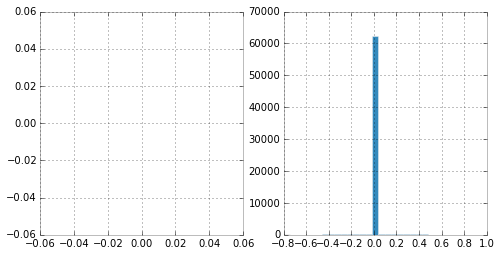

In [105]:
start = datetime.now()
N_epochs = 20
for i in range(N_epochs):
    rbm.one_epoch()
print "{} epochs took {}".format(N_epochs, datetime.now()-start)
fig1, ax1 = plt.subplots(1,2, figsize=(8,4))
ax1[0].plot(rbm.dWs,',')
histstuff = ax1[1].hist(rbm.W.flat, bins=30);

In [79]:
1./0.69

1.4492753623188408

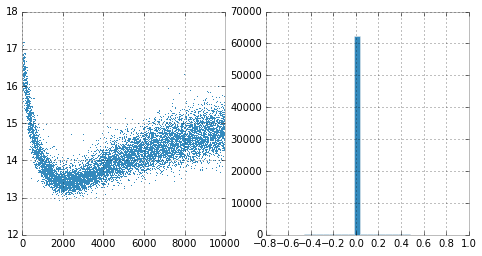

In [106]:
fig1, ax1 = plt.subplots(1,2, figsize=(8,4))
ax1[0].plot(rbm.dWs,',')
histstuff = ax1[1].hist(rbm.W.flat, bins=30);

0.874393008362 -0.797278810191


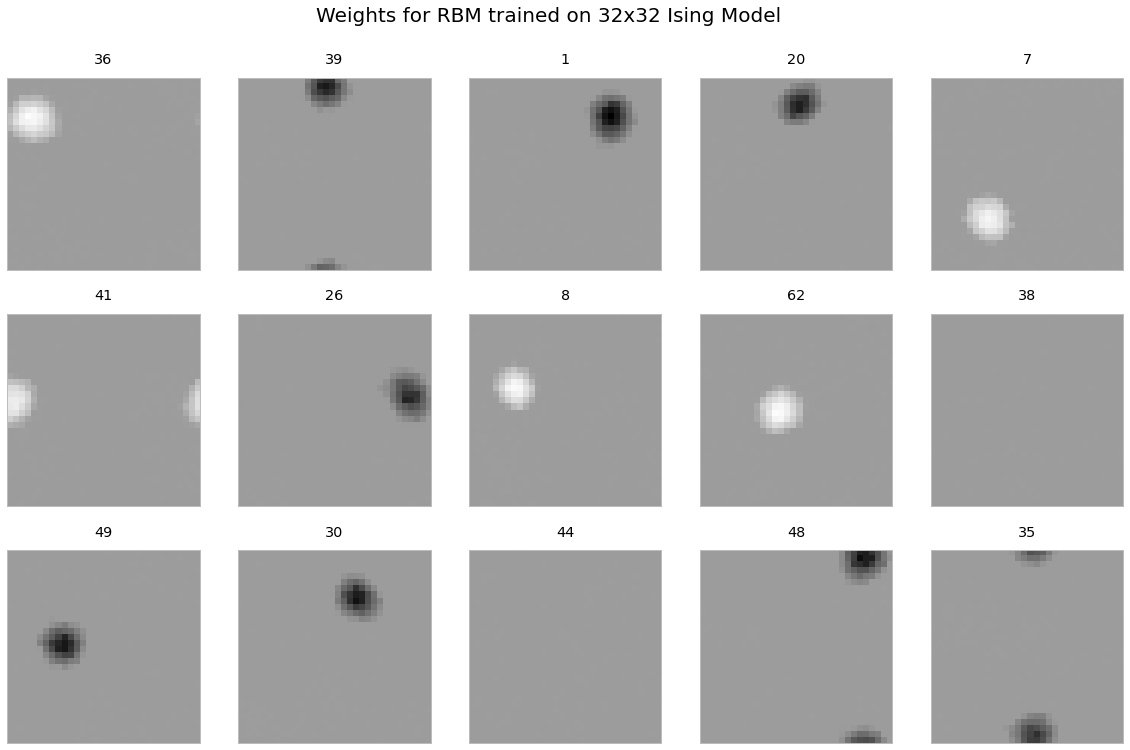

In [107]:
imagerbm = rbm
fig, axs = plt.subplots(3,5, figsize=(20,12))
selection = np.random.randint(0,high=imagerbm.W.shape[1], size=3*5)
mx, mn = imagerbm.W.max(), imagerbm.W.min()
print mx, mn
for ax, s in zip(axs.flat, selection):
    ax.matshow(imagerbm.W[:,s].reshape(32,32), cmap="Greys", vmin=mn, vmax=mx)
    ax.set_title(str(s))
    ax.set_xticks([])
    ax.set_yticks([])
    plt.suptitle('Weights for RBM trained on 32x32 Ising Model', fontsize=20)
#plt.colorbar()

In [31]:
def hiddenHamiltonian(W, beta):
    H = lambda h: -np.sum(np.log(2*np.cosh(beta*W.dot(h))))/beta
    return H
H = hiddenHamiltonian(rbm.W, 1.)
h_list = []
s_state = None

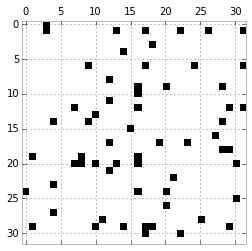

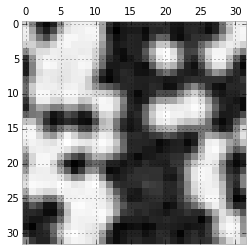

In [104]:
white = np.zeros(32*32)
centers = np.argmax(rbm.W, 0)
for c in centers:
    white[c] = 1
plt.matshow(white.reshape(32,32), cmap='Greys')
plt.matshow(rbm.W.sum(1).reshape(32,32), cmap='Greys')

In [68]:
for i in range(1000):
    s_state, h_state, p_s, p_h = rbm._gibbs_sample_hsh(s_state)
    h_list += [h_state]

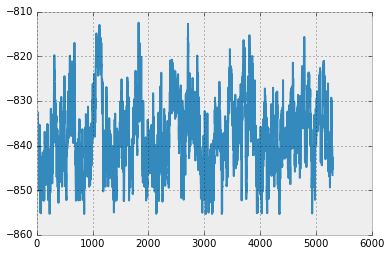

In [74]:
h_energies = map(H, h_list)
plt.plot(h_energies)

<matplotlib.colorbar.Colorbar instance at 0x1282a83f8>

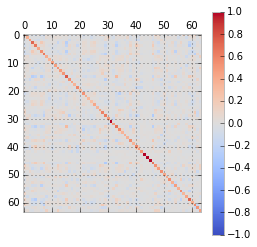

In [70]:
harr = np.array(h_list).astype('float')
harr -= harr.mean(0)
hcorr = np.einsum('ni,nj->ij',harr,harr)/harr.shape[0]
plt.matshow(hcorr, cmap='coolwarm', vmin=-1, vmax=1.)
plt.colorbar()

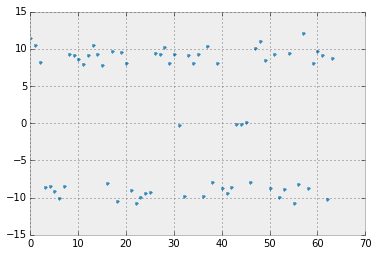

In [83]:
plt.plot(rbm.W.sum(0), '.')

#Testing RBM class with fabricated data:

##Sample from these possible states:

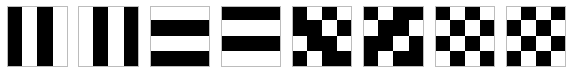

In [2]:
foo = np.ones(16)
hbarl = np.array([foo[i]*(-1)**(i%2) for i in range(16)])
hbarr = np.array([foo[i]*(-1)**(i%2+1) for i in range(16)])
vbart = (hbarl.reshape(4,4).T).ravel()
vbarb = (hbarr.reshape(4,4).T).ravel()
birdlr = np.array([foo[i]*(-1)**(i%3) for i in range(16)])
birdll = np.array([foo[i]*(-1)**(i%5) for i in range(16)])
check1 = np.array([foo[i]*(-1)**(i%2+(i/4)%2) for i in range(16)])
check2 = np.array([foo[i]*(-1)**(i%2+(i/4)%2+1) for i in range(16)])
formlist = [hbarl, hbarr, vbarb, vbart, birdll, birdlr, check1, check2]
fig, axs = plt.subplots(1,8, figsize = (10,80))
for n, ax in enumerate(axs.flat):
    ax.matshow(formlist[n].reshape(4,4), cmap='Greys')
    ax.set_xticks([])
    ax.set_yticks([])

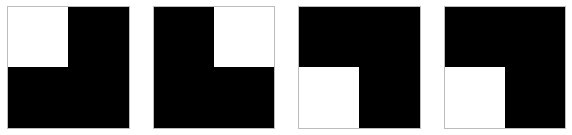

In [7]:
upleft = np.ones(16)
upleft[0], upleft[1], upleft[4], upleft[5] = -1, -1, -1, -1
upright = upleft.reshape(4,4)[:,::-1].ravel()
downleft = upleft.reshape(4,4)[::-1,:].ravel()
downright = upright.reshape(4,4)[::-1,::-1].ravel()
cornerforms = [upleft, upright, downleft, downright]
fig, axs = plt.subplots(1,4, figsize = (10,40))
for n, ax in enumerate(axs.flat):
    ax.matshow(cornerforms[n].reshape(4,4), cmap='Greys')
    ax.set_xticks([])
    ax.set_yticks([])

In [8]:
N_samples = 400
forms = cornerforms
evenprop = [1./len(forms) for i in range(len(forms))]
cumprop = np.cumsum(evenprop)
part = [np.around(ep*N_samples) for ep in evenprop]
fakedata = []
for nf, p in enumerate(part):
    for i in range(int(p)):
        fakedata += [forms[nf]]
fakedata = np.array(fakedata)*(2*(np.random.rand(N_samples)>0.5)-1)[:,None]
np.random.shuffle(fakedata)

In [12]:
testrbm = RBM(s = fakedata, N_h = len(forms), k=2, batchsize=40, sparsity=0.005, mom=0.5, verbose=True)

3000 epochs took 0:00:35.850417


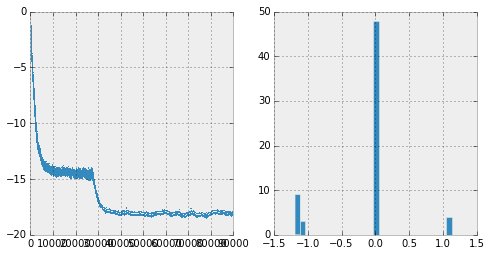

In [15]:
start = datetime.now()
N_testepochs = 3000
for i in range(N_testepochs):
    testrbm.one_epoch()
print "{} epochs took {}".format(N_testepochs, datetime.now()-start)
fig1, ax1 = plt.subplots(1,2, figsize=(8,4))
ax1[0].plot(testrbm.E_list,',')
histstuff = ax1[1].hist(testrbm.W.flat, bins=30);

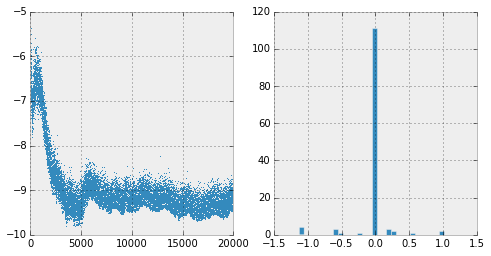

In [499]:
fig1, ax1 = plt.subplots(1,2, figsize=(8,4))
ax1[0].plot(testrbm.E_list,',')
histstuff = ax1[1].hist(testrbm.W.flat, bins=30);

1.12613592076 -1.18813151723


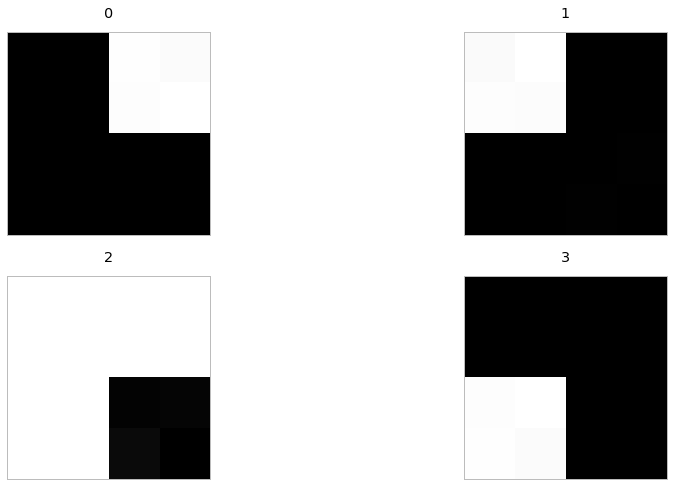

In [16]:
fig, axs = plt.subplots(2,testrbm.N_h/2, figsize=(15, 8))
mx, mn = testrbm.W.max(), testrbm.W.min()
print mx, mn
for s, ax in enumerate(axs.flat):
    ax.matshow(testrbm.W[:,s].reshape(4,4), cmap="Greys")#, vmin=mn, vmax=mx)
    ax.set_title(str(s))
    ax.set_xticks([])
    ax.set_yticks([])
#plt.colorbar()

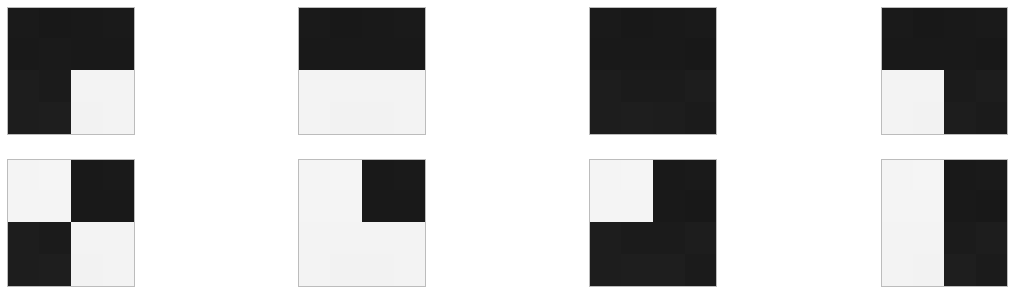

In [18]:
hstates = map(list, list(product([-1,1], repeat=(len(forms)))))[:8]
fig, axs = plt.subplots(2,len(hstates)/2, figsize=(20,5))
for hs, ax in zip(hstates, axs.flat):
    ax.matshow(testrbm._sample_s_given_h(hs)[1].reshape(4,4),cmap='Greys', vmin=0, vmax=1.)
    ax.set_xticks([])
    ax.set_yticks([])

#Minimum Probability Flow Learning

In [3]:
isingspins32.shape

(50000, 1024)

In [ ]:
from scipy import cosh, tanh

In [ ]:
def K_dK_MPF(weights, data):
    n, v = data.shape #n = samples, v = visible units
    W = weights.reshape(v, -1)
    sdotW = data.dot(W)[:,:,None]
    sdotWflip = sdotW-2*(W.T*data[:,None])
    Ksl_log = np.exp(0.5*np.log(cosh(sdotWflip)/cosh(sdotW)).sum(1))
    K_obj = np.sum(Ksl_log)/n
    tanh_sdotWflip = tanh(sdotWflip)
    dK1 = np.einsum('nl,np,nql->pq',Ksl_log,data,tanh_sdotWflip-tanh(sdotW))
    dK2 = np.einsum('np,np,nqp->pq',Ksl_log,2*data,tanh_sdotWflip)
    dK_obj = 0.5/n*(dK1-dK2).ravel()
    return K_obj, dK_obj

In [130]:
W = np.random.randn(32,8)
s = 2*(np.random.rand(20,32)>0.5)-1
grad = approx_fprime(W.ravel(), lambda x: K_dK_MPF(x, s)[0], epsilon=1E-7)
k, dk = K_dK_MPF(W.ravel(), s)
np.sqrt(np.mean((dk - grad)**2))

6.0868988808210795e-05

In [150]:
%time k, dk = K_dK_MPF(optimizer.theta, isingspins32[:100])
print k

CPU times: user 11.9 s, sys: 132 ms, total: 12.1 s
Wall time: 11.3 s
 830.22084792


In [142]:
initial_p = np.random.randn(isingspins32.shape[1]*64)/64
optimizer = SFO(K_dK_MPF, initial_p, [isingspins32[i*200:(i+1)*200] for i in range(250)])

In [151]:
optimizer.optimize(1)

pass 1.048, step 0, active 52/250, sfo time 77.6358523369 s, func time 5482.96685457 s, f 801.509939709, <f> 817.484696189
pass 1.052, step 1, active 52/250, sfo time 77.9862015247 s, func time 5503.05578041 s, f 809.160404069, <f> 817.524424927
pass 1.056, step 2, active 52/250, sfo time 78.3146183491 s, func time 5524.58148861 s, f 810.481704494, <f> 817.563619859
pass 1.06, step 3, active 52/250, sfo time 78.615139246 s, func time 5546.64014482 s, f 794.841399633, <f> 817.638371681
pass 1.064, step 4, active 52/250, sfo time 78.8799669743 s, func time 5566.59338999 s, f 820.940274244, <f> 817.422218711
pass 1.068, step 5, active 52/250, sfo time 79.1584947109 s, func time 5589.13623714 s, f 820.748308842, <f> 817.168612467
pass 1.072, step 6, active 52/250, sfo time 79.430249691 s, func time 5612.40252519 s, f 814.082111359, <f> 817.223543143
pass 1.076, step 7, active 52/250, sfo time 79.751875639 s, func time 5634.15322924 s, f 814.599070016, <f> 816.992306554
pass 1.08, step 8, a

array([ 0.03740416, -0.01476642,  0.00696864, ...,  0.05167739,
        0.13958861, -0.05852773])

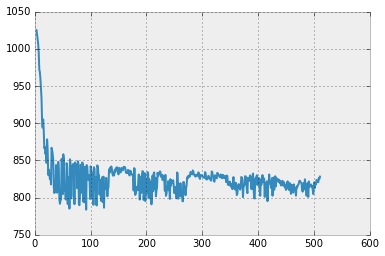

In [152]:
plt.plot(optimizer.hist_f_flat)

0.458139183898 -0.373880978794


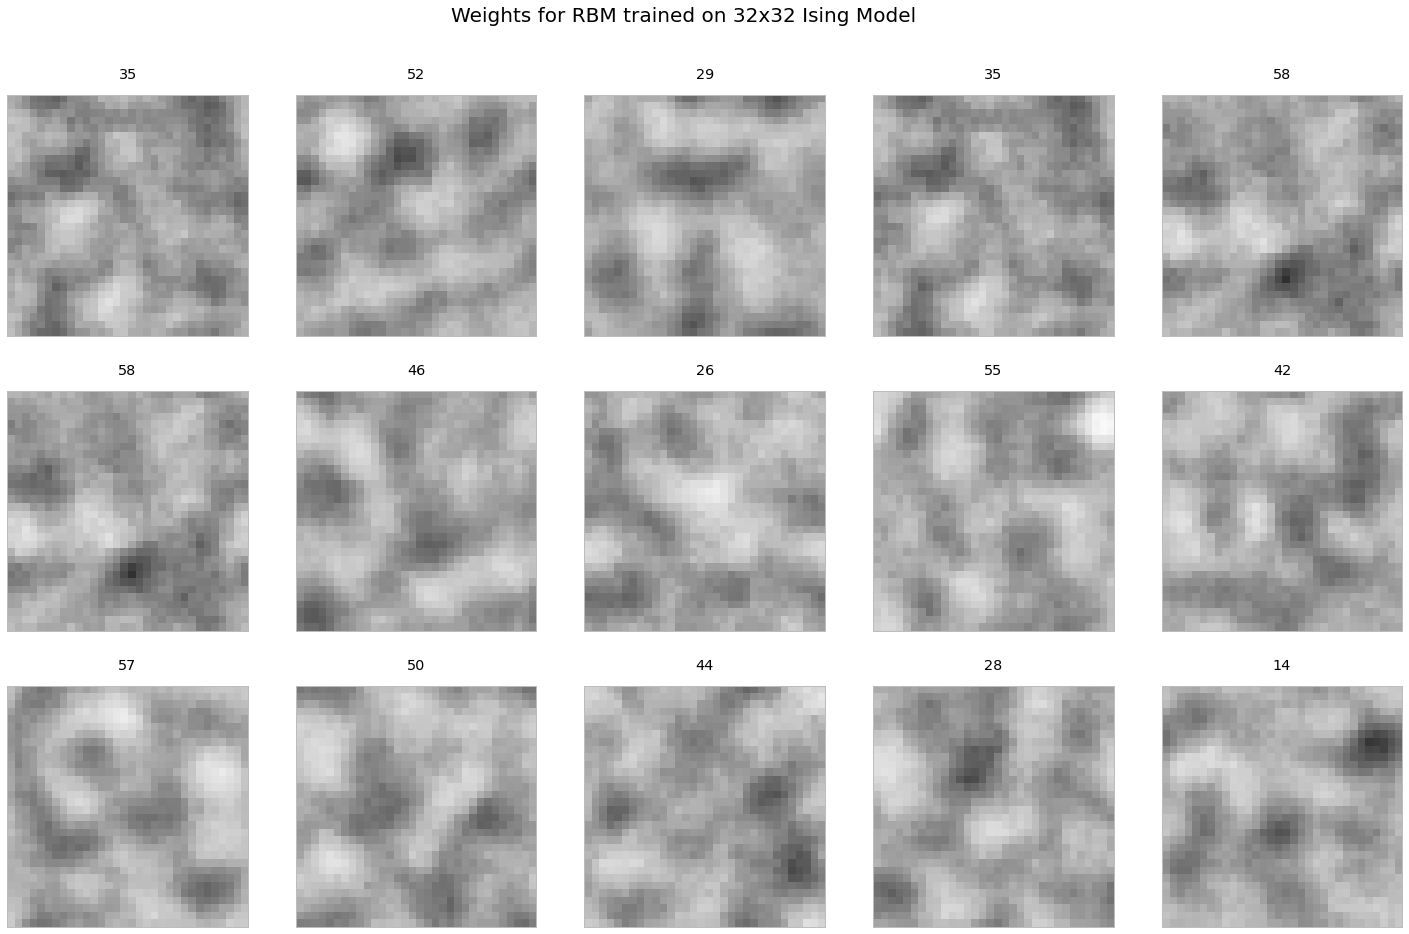

In [153]:
W = optimizer.theta.reshape(isingspins32.shape[1], -1)
fig, axs = plt.subplots(3,5, figsize=(25,15))
selection = np.random.randint(0,high=W.shape[1], size=3*5)
mx, mn = W.max(), W.min()
print mx, mn
for ax, s in zip(axs.flat, selection):
    ax.matshow(W[:,s].reshape(32,32), cmap="Greys", vmin=mn, vmax=mx)
    ax.set_title(str(s))
    ax.set_xticks([])
    ax.set_yticks([])
    plt.suptitle('Weights for RBM trained on 32x32 Ising Model', fontsize=20)

##Convolutional RBM

  * To do: mirror/$\frac{\pi}{2}$ rotation symmetry

In [18]:
numSamp, N_v = isingspins32.shape
L_v = int(np.sqrt(N_v))
b = 4
l=5
L_h = L_v/b
N_h = L_h*L_h
stencil = np.random.randn(L_v,L_v)#isingspins32[0].reshape(L_v,L_v)
mask = np.outer(np.arange(L_v) < l, np.arange(L_v) < l)
stencil *= mask
W = np.zeros((L_v, L_v, L_h, L_h))
for i in range(L_h):
    for j in range(L_h):
        shifted = np.roll(np.roll(stencil, b*i, axis=0),b*j, axis=1)
        W[:,:,i,j] = shifted

In [1]:
run convrbm.py

In [6]:
conv = ConvRBM(isingspins32, 2)
print conv.W.shape

(1024, 256)


In [7]:
%time foo = [conv.one_epoch() for i in range(5)];

CPU times: user 6min 58s, sys: 10.6 s, total: 7min 9s
Wall time: 1min 48s


<matplotlib.colorbar.Colorbar instance at 0x11779ed40>

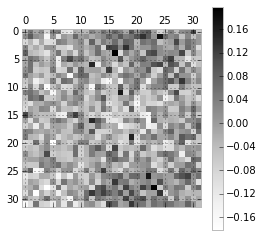

In [9]:
plt.matshow(np.roll(conv.filter, 20,1), cmap="Greys")
plt.colorbar()

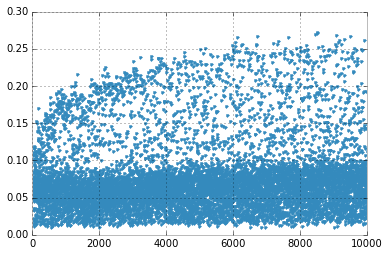

In [132]:
plt.plot(conv.dWs,'.')

<matplotlib.colorbar.Colorbar instance at 0x117a95ef0>

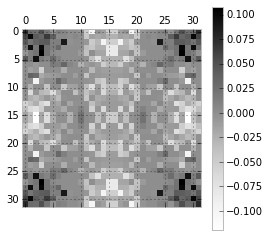

In [10]:
testsum = conv.W[:,0]#.sum(1)
f = conv._getFilterUpdate(conv.W)
plt.matshow(f,cmap='Greys', vmin=f.min(), vmax=f.max())
plt.colorbar()

####Bake in symmetries

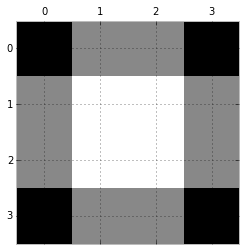

In [159]:
from collections import defaultdict
l=4
if l%2:
    cent = l/2
else:
    cent = l/2 - 0.5
#d = np.zeros((l,l))
pdict = defaultdict(int)
d = np.array([[int((i-cent)**2+(j-cent)**2-(l%2==0)*0.5) for i in range(l)] for j in range(l)])
for dist in d.ravel():
    pdict[dist] = np.random.rand()
wmat = np.zeros((l,l))
for i in range(l):
    for j in range(l):
        wmat[i,j] = pdict[d[i,j]]
plt.matshow(wmat, cmap='Greys')

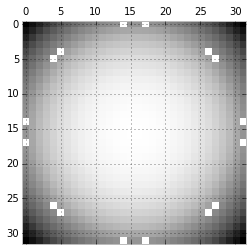

In [136]:
k = d.copy()
for (i,j) in pdict[pdict.keys()[15]]:
    k[i,j] = 0
plt.matshow(k, cmap='Greys')

####Make graph structure

In [189]:
l = 4
b = 2
L_v = 8
N_v = L_v**2
L_h = L_v/b
N_h = L_h**2
v_ind = range(N_v)
h_ind = range(N_h)
h_conn = defaultdict(list)
h_ind = [1*L_h + 1]
for i in range(l):
    for j in range(l):
        for h in h_ind:
            vi, vj = 2*h/L_h, 2*h%L_h
            vih = (vi+i*L_v)%L_v
            vjh = (vj+j - ((vj+j)/L_v)*L_v)%L_v
            h_conn[h] += [vih*L_v+vjh]

In [190]:
print h_ind
print hi, hj, vih, vjh

[5]
1 1 26 5


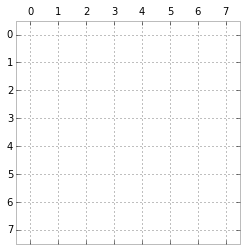

In [191]:
foo = np.zeros((L_v,L_v))
for ind in h_conn[225]:
    i = ind/L_v
    j = ind%L_v
    print i,j
    foo[i,j]=1
plt.matshow(foo, cmap='Greys')

In [192]:
h_conn

defaultdict(<type 'list'>, {225: [], 5: [18, 19, 20, 21, 82, 83, 84, 85, 146, 147, 148, 149, 210, 211, 212, 213]})